<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANwithPyTorch/blob/main/15_gan_cnn_celeba_refinements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LeakyReLU() 대신 GELU로 성능 향상 시키기

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda: ", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda:  Tesla K80


device(type='cuda')

helper 함수들

In [4]:
def generate_random_image(size):
  return torch.rand(size)

def generate_random_seed(size):
  return torch.randn(size)

In [5]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

In [6]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]

Dataset 클래스

In [7]:
class CelebADataset(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass


  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, index):
    if (index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg']) 
    img = crop_centre(img, 128, 128)
    return torch.cuda.FloatTensor(img).permute(2, 0, 1).view(1, 3, 128, 128) / 255.0


  def plot_images(self, index):
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    img = crop_centre(img, 128, 128)
    plt.imshow(img, interpolation = 'nearest')
    pass


  pass 

In [8]:
celeba_dataset = CelebADataset('/content/mount/MyDrive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py')

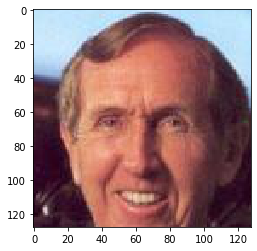

In [ ]:
celeba_dataset.plot_images(20)

In [9]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        # (1, 3, 128, 128)
        nn.Conv2d(3, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.GELU(),

        nn.Conv2d(256, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.GELU(),

        nn.Conv2d(256, 3, kernel_size = 8, stride = 2),
        nn.GELU(),

        View(3*10*10),
        nn.Linear(3*10*10, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0;
    self.progress = []

    pass


  def forward(self, inputs):
    return self.model(inputs)


  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 1000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

판별기 테스트

In [ ]:
%%time

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((1, 3, 128, 128)), torch.cuda.FloatTensor([0.0]))
  pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 19min 55s, sys: 8.46 s, total: 20min 3s
Wall time: 20min


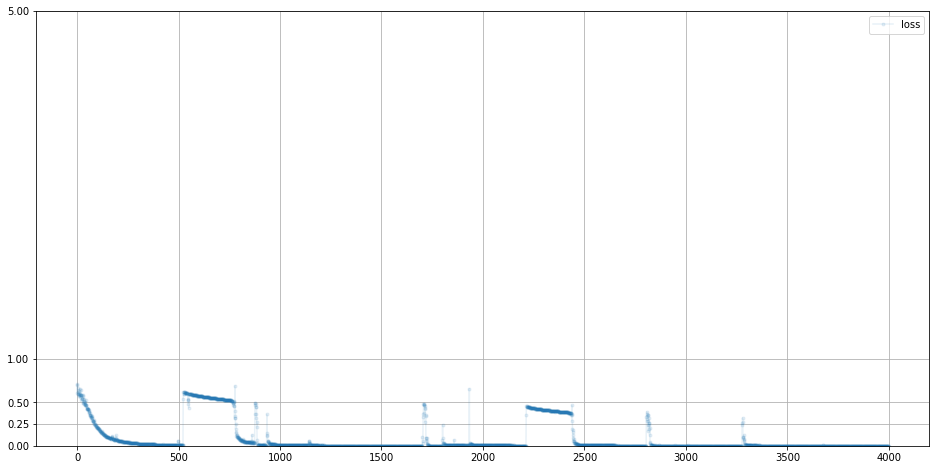

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0, 20000)]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image((1, 3, 128, 128))).item())
  pass

1.0
1.0
1.0
1.0
0.0004902450600638986
0.0005080078262835741
0.0005104245501570404
0.00047279178397729993


In [10]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.model = nn.Sequential(
        # 입력은 1차원 행렬
        nn.Linear(100, 3*11*11),
        nn.GELU(),

        View((1, 3, 11, 11)),

        nn.ConvTranspose2d(3, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.GELU(),

        nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.GELU(),

        nn.ConvTranspose2d(256, 3, kernel_size = 8, stride = 2, padding = 1),
        nn.BatchNorm2d(3),
        
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  
  def forward(self, inputs):
    return self.model(inputs)


  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
  pass

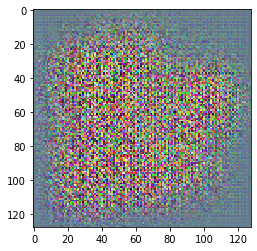

In [ ]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
plt.imshow(img, interpolation = 'none')

GAN 훈련

In [11]:
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=363, bias=True)
    (1): GELU()
    (2): View()
    (3): ConvTranspose2d(3, 256, kernel_size=(8, 8), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU()
    (6): ConvTranspose2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU()
    (9): ConvTranspose2d(256, 3, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)

In [12]:
%%time 

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 29min 43s, sys: 9.9 s, total: 29min 53s
Wall time: 30min 5s


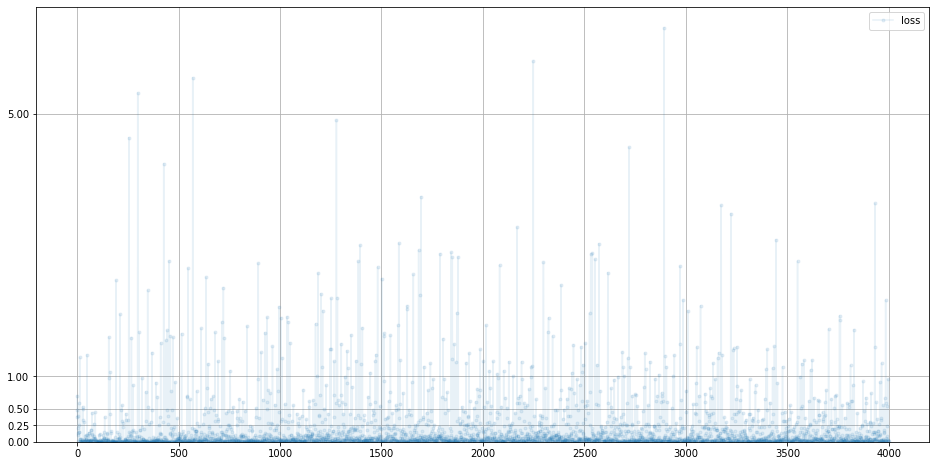

In [13]:
D.plot_progress()

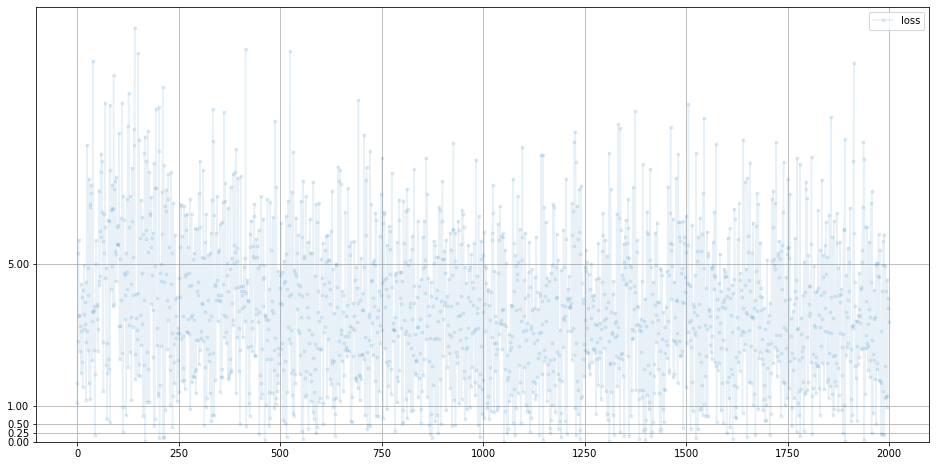

In [14]:
G.plot_progress()

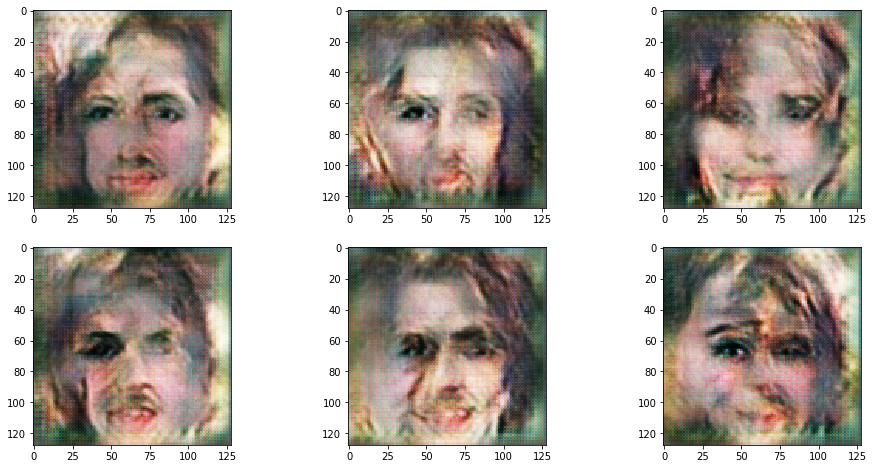

In [15]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [16]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.1433086395263672

In [17]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.17328929901123047